In [ ]:
'''This script is going to create a model to differentiate cases into differnt categories.
Unsupervised learning will be used to create the categories.
The reasoning behind this, is to be able to assign each observation to a category, and then create a custom
regression model for each category to predict the LOS.'''
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils import (
    describe_dataframe, df_train_test, graph_results, reg_train_eval
)

In [27]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

wdf_rest_te = pd.concat([wdf_rest_te.reset_index(drop=True), ohe_df_rest_te.reset_index(drop=True)], axis=1)
wdf_2022_te = pd.concat([wdf_2022_te.reset_index(drop=True), ohe_df_2022_te.reset_index(drop=True)], axis=1)

reg_mod_metrics = {"Test":{},
                   "Train":{}}

predictions = {}

X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(wdf_rest_te, "LOS", 0.2)

X_train_2022_te, X_test_2022_te, y_train_2022_te, y_test_2022_te = df_train_test(wdf_2022_te, "LOS", 0.2)

(20867, 1)
(20867,)


In [ ]:
#Scaling
#scaler = StandardScaler()
#X_train_rest_te = scaler.fit_transform(X_train_rest_te)
#X_test_rest_te = scaler.transform(X_test_rest_te)
#X_train_2022_te = scaler.fit_transform(X_train_2022_te)
#X_test_2022_te = scaler.transform(X_test_2022_te)

In [28]:
X_train_2022_te.shape[1]

68

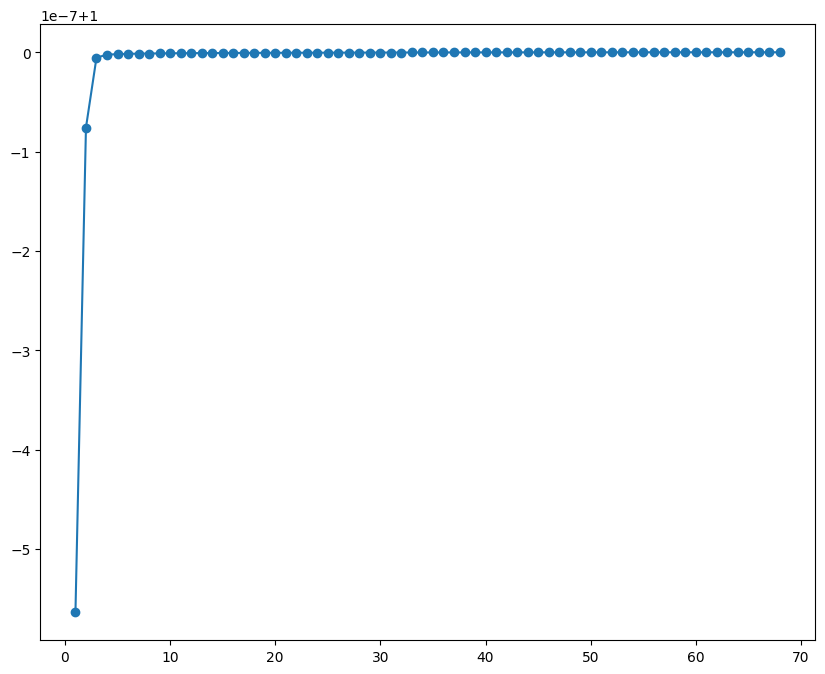

In [29]:
#PCA
pca = PCA()
pca.fit(X_train_rest_te)
pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(range(1,X_train_rest_te.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o')

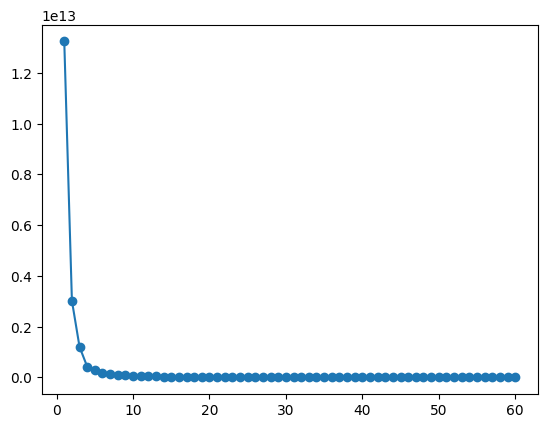

In [30]:
pca = PCA(n_components=63) #information gain after n_components>63 is negligible
pca.fit(X_train_rest_te)
scores_pca = pca.transform(X_train_rest_te)
wcss = []
for i in range(1,61):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1,61), wcss, marker = 'o')
# Looks like 50 something clusters is the best choice, but that is clinically unreasonable (maybe?)


(20867, 1)
(20867,)


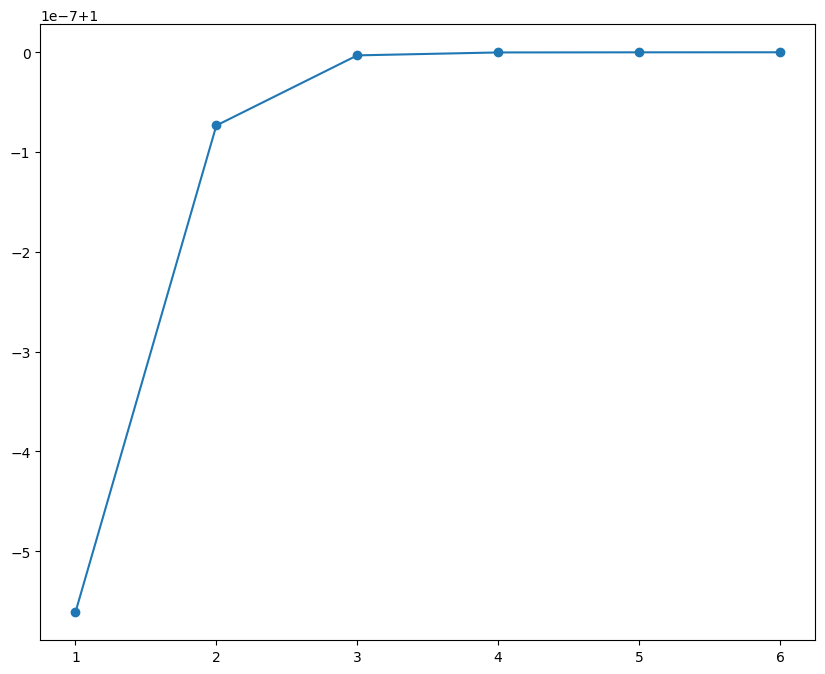

In [37]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
no_state_wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
no_state_wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(no_state_wdf_rest_te, "LOS", 0.2)
X_train_2022_te, X_test_2022_te, y_train_2022_te, y_test_2022_te = df_train_test(no_state_wdf_2022_te, "LOS", 0.2)


#scaler = StandardScaler()
#X_train_rest_te = scaler.fit_transform(X_train_rest_te)
#X_test_rest_te = scaler.transform(X_test_rest_te)
#X_train_2022_te = scaler.fit_transform(X_train_2022_te)
#X_test_2022_te = scaler.transform(X_test_2022_te)

pca = PCA()
pca.fit(X_train_rest_te)
pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(range(1,X_train_rest_te.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o')

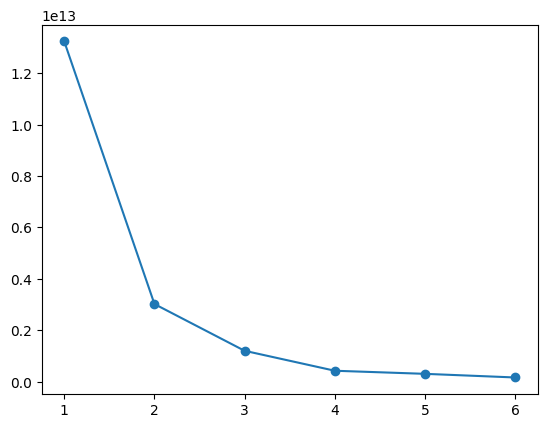

In [ ]:
pca = PCA(n_components=3) 
pca.fit(X_train_rest_te)
scores_pca = pca.transform(X_train_rest_te)
scores_pca_2022 = pca.transform(X_train_2022_te)
wcss = []
for i in range(1,7):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1,7), wcss, marker = 'o')
# Looks like 50 something clusters is the best choice, but that is clinically unreasonable (maybe?)

In [ ]:
# Choosing 2 clusters (based on data with and without state)

kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)

kmeans_pca.fit(scores_pca)
X_train_rest_te['kmeans_cluster'] = kmeans_pca.labels_

kmeans_pca.fit(scores_pca_2022)
X_test_2022_te['kmeans_cluster'] = kmeans_pca.labels_

In [ ]:
# Rest of the data
x_train_rest_te_0 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0]
y_train_rest_te_0 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0].index]

x_train_rest_te_1 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1]
y_train_rest_te_1 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1].index]

# 2022 + data
x_test_2022_te_0 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0]
y_test_2022_te_0 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0].index]

6191     1
9725     0
17799    0
20733    1
12041    1
        ..
7740     0
13971    0
14817    0
6621     0
19619    0
Name: LOS, Length: 12988, dtype: int64

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_0, y_train_rest_te_0)

In [ ]:
best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=5, 
                                   min_samples_split= 2,
                                   min_samples_leaf=6, 
                                   n_estimators=300,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_0,
               y_train_rest_te_0,
               x_test_2022_te_0,
               y_test_2022_te_0,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-gridcv_best")

reg_mod_metrics['Test']

In [ ]:
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.3),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators': stats.randint(50, 300)
}

rf_mod = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    rf_mod, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=5, 
    scoring='r2'
)